In [ ]:
#CREDITS TO:
#https://github.com/gurkandemir/Bag-of-Visual-Wordsimport

import numpy as np 
import os
import cv2
from sklearn.cluster import KMeans
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


In [ ]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(path +'/'+ folder):
            images.append(path+'/' + folder  + '/'+  file)

    if(train is True):
        np.random.shuffle(images)
    
    return images

In [ ]:
def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def getDescriptorsFast(image,keypoints, sift):
    kp, des = sift.compute(image, keypoints)
    return des

def readImage(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img,(128,64))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    return descriptors

In [ ]:

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def extractFeaturesHog(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i]
            # feature = feature.reshape(1, -1)
            feature = np.reshape(feature, (-1, 1)).T
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (807 / (7 * 140)),
        1: (807 / (7 * 140)),
        2: (807 / (7 * 133)),
        3: (807 / (7 * 70)),
        4: (807 / (7 * 42)),
        5: (807 / (7 * 140)),
        6: (807 / (7 * 142)) 
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["city", "face", "green", "house_building", "house_indoor", "office", "sea"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))


1- Find training images path.
2- Read train images, and compute SIFT descriptors.
3- Find the dictionary.
4- Quantize features.
5- Classify test images.

#SIFT

In [ ]:

def trainModelSift(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = 7
    image_count = len(images)

    for img_path in images:
        if("city" in img_path):
            class_index = 0
        elif("face" in img_path):
            class_index = 1
        elif("green" in img_path):
            class_index = 2
        elif("house_building" in img_path):
            class_index = 3
        elif("house_indoor" in img_path):
            class_index = 4
        elif("office" in img_path):
          class_index = 5
        else:
          class_index = 6

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

In [ ]:

def testModelSift(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "city",
        "1": "face",
        "2": "green",
        "3": "house_building",
        "4": "house_indoor",
        "5": "office",
        "6": "sea"
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("city" in img_path):
                true.append("city")
            elif("face" in img_path):
                true.append("face")
            elif("green" in img_path):
                true.append("green")
            elif("house_building" in img_path):
                true.append("house_building")
            elif("house_indoor" in img_path):
                true.append("house_indoor")
            elif("office" in img_path):
                true.append("office")
            else:
                true.append("sea")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")

#HOG

In [ ]:

def trainModelHog(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    descriptor_list = []
    train_labels = np.array([])
    label_count = 7
    image_count = len(images)

    for img_path in images:
        if("city" in img_path):
            class_index = 0
        elif("face" in img_path):
            class_index = 1
        elif("green" in img_path):
            class_index = 2
        elif("house_building" in img_path):
            class_index = 3
        elif("house_indoor" in img_path):
            class_index = 4
        elif("office" in img_path):
          class_index = 5
        else:
          class_index = 6

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
      
        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=False)

        descriptor_list.append(fd)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")


    im_features = extractFeaturesHog(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

In [ ]:

def testModelHog(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "city",
        "1": "face",
        "2": "green",
        "3": "house_building",
        "4": "house_indoor",
        "5": "office",
        "6": "sea"
    }

    for img_path in test_images:
        img = readImage(img_path)

        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=False)

        if(fd is not None):
            count += 1
            descriptor_list.append(fd)

            if("city" in img_path):
                true.append("city")
            elif("face" in img_path):
                true.append("face")
            elif("green" in img_path):
                true.append("green")
            elif("house_building" in img_path):
                true.append("house_building")
            elif("house_indoor" in img_path):
                true.append("house_indoor")
            elif("office" in img_path):
                true.append("office")
            else:
                true.append("sea")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeaturesHog(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")

#FAST

In [ ]:

def trainModelFast(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")

    # Initiate FAST
    fast = cv2.FastFeatureDetector_create(threshold=25)
    fast.setNonmaxSuppression(True)


    sift = cv2.xfeatures2d.SIFT_create()

    descriptor_list = []
    train_labels = np.array([])
    label_count = 7
    image_count = len(images)

    for img_path in images:
        if("city" in img_path):
            class_index = 0
        elif("face" in img_path):
            class_index = 1
        elif("green" in img_path):
            class_index = 2
        elif("house_building" in img_path):
            class_index = 3
        elif("house_indoor" in img_path):
            class_index = 4
        elif("office" in img_path):
          class_index = 5
        else:
          class_index = 6

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
      
        kp = fast.detect(img,None)
        des = getDescriptorsFast(img,kp,sift)

        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

In [ ]:

def testModelFast(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "city",
        "1": "face",
        "2": "green",
        "3": "house_building",
        "4": "house_indoor",
        "5": "office",
        "6": "sea"
    }

  

    # Initiate FAST 
    fast = cv2.FastFeatureDetector_create(threshold=25)
    fast.setNonmaxSuppression(True)

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)

        kp = fast.detect(img,None)
        des = getDescriptorsFast(img,kp,sift)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("city" in img_path):
                true.append("city")
            elif("face" in img_path):
                true.append("face")
            elif("green" in img_path):
                true.append("green")
            elif("house_building" in img_path):
                true.append("house_building")
            elif("house_indoor" in img_path):
                true.append("house_indoor")
            elif("office" in img_path):
                true.append("office")
            else:
                true.append("sea")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")

In [ ]:
def executeSift(train_path, test_path, no_clusters, kernel):
    kmeans, scale, svm, im_features = trainModelSift(train_path, no_clusters, kernel)
    testModelSift(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)

In [ ]:
def executeHog(train_path, test_path, no_clusters, kernel):
    kmeans, scale, svm, im_features = trainModelHog(train_path, no_clusters, kernel)
    testModelHog(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)

In [ ]:
def executeFast(train_path, test_path, no_clusters, kernel):
    kmeans, scale, svm, im_features = trainModelFast(train_path, no_clusters, kernel)
    testModelFast(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)

In [ ]:
!pip install opencv-contrib-python==4.4.0.44

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
train_path = "/content/drive/My Drive/Colab Notebooks/VP/dataset/train"
test_path = "/content/drive/My Drive/Colab Notebooks/VP/dataset/test"



Mounted at /content/drive/


Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


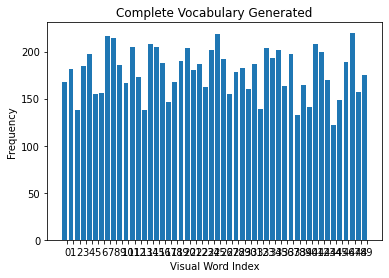

Features histogram plotted.
0.5 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[17  2  4  3  0  1  3]
 [ 2 22  2  0  0  4  0]
 [ 4  5 17  1  1  0  2]
 [ 3  2  0 15  4  3  3]
 [ 5  5  3  4  6  7  0]
 [ 3  1  0  3  5 18  0]
 [ 1  4  8  0  0  1 16]]
Normalized confusion matrix
[[0.57 0.07 0.13 0.1  0.   0.03 0.1 ]
 [0.07 0.73 0.07 0.   0.   0.13 0.  ]
 [0.13 0.17 0.57 0.03 0.03 0.   0.07]
 [0.1  0.07 0.   0.5  0.13 0.1  0.1 ]
 [0.17 0.17 0.1  0.13 0.2  0.23 0.  ]
 [0.1  0.03 0.   0.1  0.17 0.6  0.  ]
 [0.03 0.13 0.27 0.   0.   0.03 0.53]]


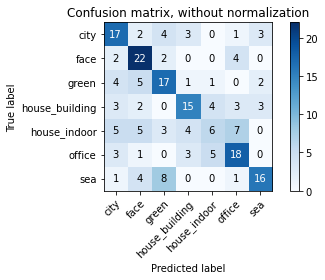

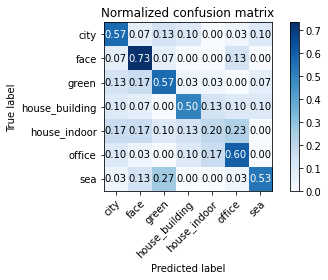

Confusion matrixes plotted.
accuracy score: 0.529
Accuracy calculated.
Execution done.


In [ ]:
executeSift(train_path, test_path, 50, 'linear')

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


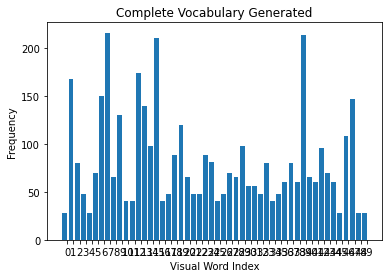

Features histogram plotted.
0.5 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[14  0  9  5  1  1  0]
 [ 2  3 20  1  1  2  1]
 [ 8  0 20  0  0  0  2]
 [ 7  0  2 14  0  3  4]
 [ 2  0  1 10  4 13  0]
 [ 3  0  2  5  3 17  0]
 [ 6  0 11  0  0  0 13]]
Normalized confusion matrix
[[0.47 0.   0.3  0.17 0.03 0.03 0.  ]
 [0.07 0.1  0.67 0.03 0.03 0.07 0.03]
 [0.27 0.   0.67 0.   0.   0.   0.07]
 [0.23 0.   0.07 0.47 0.   0.1  0.13]
 [0.07 0.   0.03 0.33 0.13 0.43 0.  ]
 [0.1  0.   0.07 0.17 0.1  0.57 0.  ]
 [0.2  0.   0.37 0.   0.   0.   0.43]]


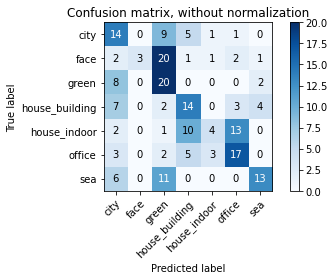

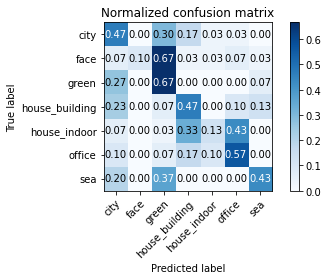

Confusion matrixes plotted.
accuracy score: 0.405
Accuracy calculated.
Execution done.


In [ ]:
executeHog(train_path, test_path, 50, 'linear')

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


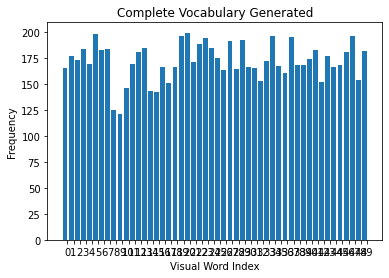

Features histogram plotted.
0.2 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[21  0  5  2  0  1  1]
 [ 0 28  1  0  0  1  0]
 [ 2  0 16  2  1  1  8]
 [ 2  0  4 14  8  0  2]
 [ 8  2  3  2  8  6  1]
 [ 1  1  3  0  4 20  1]
 [ 2  3  5  2  0  1 17]]
Normalized confusion matrix
[[0.7  0.   0.17 0.07 0.   0.03 0.03]
 [0.   0.93 0.03 0.   0.   0.03 0.  ]
 [0.07 0.   0.53 0.07 0.03 0.03 0.27]
 [0.07 0.   0.13 0.47 0.27 0.   0.07]
 [0.27 0.07 0.1  0.07 0.27 0.2  0.03]
 [0.03 0.03 0.1  0.   0.13 0.67 0.03]
 [0.07 0.1  0.17 0.07 0.   0.03 0.57]]


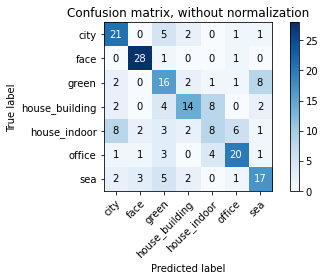

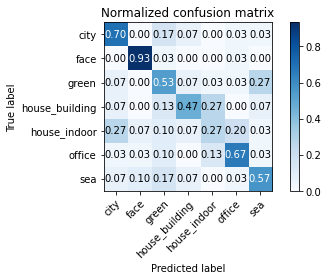

Confusion matrixes plotted.
accuracy score: 0.590
Accuracy calculated.
Execution done.


In [ ]:
executeFast(train_path, test_path, 50, 'linear')